In [2]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import swan_vis as swan 
from scipy import sparse

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

## Create a GTF with just polyA, complete, detected transcripts

In [4]:
df = pd.read_csv('../talon/human_talon_abundance_filtered.tsv', sep='\t')
_, inds = get_tpm_table(df, 
                        how='iso', 
                        sample='all', 
                        min_tpm=1,
                        gene_subset='polya',
                        nov=['Known', 'NIC', 'NNC'])

Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 194503
# isos >= 1 tpm: 175394
Applying gene type and novelty subset
Number of isos reported: 111071


In [5]:
df = df.loc[df.annot_transcript_id.isin(inds)]
print(len(df.loc[df.transcript_novelty != 'Known'].index))
df = df[['gene_ID', 'transcript_ID']]
df.to_csv('human_talon_swan_pass_list.csv', header=None, index=False)

35682


## Create SwanGraph

In [12]:
annot = '../../refs/gencode_v29_sirv4_ercc.gtf'
ab = '../talon/human_talon_abundance_filtered.tsv'
# gtf = '../talon/human_known_nic_nnc_talon.gtf'
gtf = 'human_swan_talon.gtf'

In [14]:
sg = swan.SwanGraph()
sg.add_annotation(annot)
sg.add_transcriptome(gtf)
sg.add_abundance(ab)

In [ ]:
sg.save_graph('swan')

In [ ]:
sg = swan.read('swan.p')
sg.adata.obs.head()

## Get metadata

In [ ]:
sg = swan.read('swan.p')
meta = sg.adata.obs.copy(deep=True)
meta.reset_index(inplace=True, drop=True)
meta['sample'] = meta.dataset.str.rsplit('_', n=2, expand=True)[0]

tissue_df = get_tissue_metadata()
tissue_df = tissue_df[['tissue', 'biosample']]
tissue_df.rename({'biosample': 'sample'}, axis=1, inplace=True)

meta = meta.merge(tissue_df, how='left', on='sample')
meta.head()
meta['classification'] = 'tissue'
meta.loc[meta.tissue.isnull(), 'classification'] = 'cell_line'

meta.loc[meta.tissue.isnull(), 'tissue'] = meta.loc[meta.tissue.isnull(), 'sample']
meta.drop('sample', axis=1, inplace=True)
meta.rename({'tissue': 'sample'}, axis=1, inplace=True)

ad_df = get_ad_metadata()
ad_df = ad_df[['health_status', 'hr']]
meta = meta.merge(ad_df, how='left', left_on='dataset', right_on='hr')
meta.drop('hr', axis=1, inplace=True)

print('Found {} total samples'.format(len(meta['sample'].unique().tolist())))

In [ ]:
meta.to_csv('swan_metadata.tsv', sep='\t', index=False)

## Add metadata

In [ ]:
sg = swan.read('swan.p')

In [ ]:
# edges = sg.t_df.loc[sg.t_df.tid == 'ENCODEHT000222627', 'path'].values[0]
# sg.edge_df.loc[edges]
# v1s = sg.edge_df.loc[edges, 'v1'].tolist()
# v2s = sg.edge_df.loc[edges, 'v2'].tolist()
# print(sg.loc_df.loc[v1s])
# print(sg.loc_df.loc[v2s])

In [ ]:
meta = 'swan_metadata.tsv'
sg.add_metadata('swan_metadata.tsv')

# colors
c_dict, order = get_biosample_colors()
sg.set_metadata_colors('sample', c_dict)

c_dict, order = get_ad_colors()
sg.set_metadata_colors('health_status', c_dict)

sg.save_graph('swan')

## Add triplet IDs

In [20]:
# get list of detected filtered isoforms
sg = swan.read('swan.p')
df = pd.read_csv('../talon/human_talon_abundance_filtered.tsv', sep='\t')
t_df, regions, counts = get_ic_tss_tes(sg,
                                         df,
                                         min_tpm=1, 
                                         gene_subset='polya',
                                         annot_slack=200,
                                         novel_slack=100)

t_df = t_df[['tid', 'ttrip']]
sg.t_df = sg.t_df.merge(t_df, how='left', left_index=True, right_on='tid')
sg.t_df.drop(['tid_y', 'tid_x'], axis=1, inplace=True)
swan.set_dupe_index(sg.t_df, 'tid')
sg.t_df['tid'] = sg.t_df.index.tolist()

sg.t_df.loc[sg.t_df.ttrip.isnull(), 'ttrip'] = sg.t_df.loc[sg.t_df.ttrip.isnull()].index.tolist()

Read in graph from swan.p


NameError: name 'get_ic_tss_tes' is not defined

In [ ]:
print(len(sg.t_df.loc[sg.t_df.index == sg.t_df.ttrip].index))
print(len(sg.t_df.index))
sg.t_df.head()

In [ ]:
# save swangraph with new triplet-based transcript identifiers
sg.save_graph('swan')

## Pi / major isoform stuff

Read in graph from swan.p


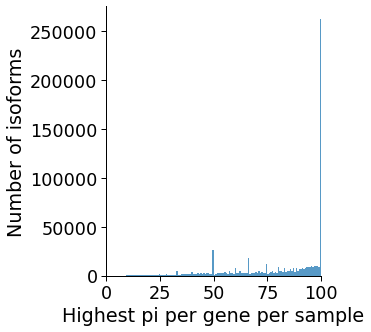

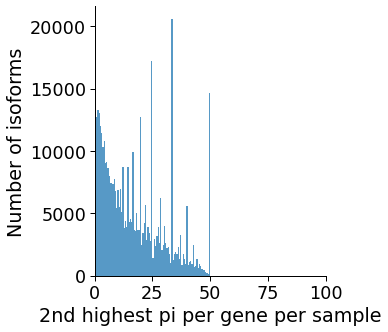

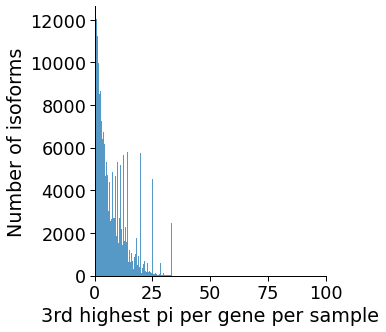

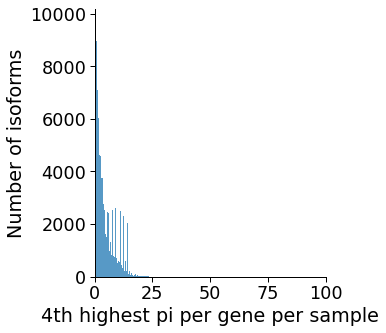

In [17]:
sg = swan.read('swan.p')
plot_major_iso_pis(sg, 'sample', opref='figures/human')

### How many isoforms does it take to get 90% expression / gene / sample?

In [20]:
sg = swan.read('swan.p')
t_df = pd.read_csv('../talon/human_talon_abundance_filtered.tsv', sep='\t')

Read in graph from swan.p


In [21]:
t_df = t_df[['annot_gene_name', 'annot_transcript_id', 'annot_gene_id']]
t_df.rename({'annot_gene_name': 'gname',
             'annot_gene_id': 'gid',
             'annot_transcript_id': 'tid'}, 
             axis=1, 
             inplace=True)

df, _ = swan.calc_pi(sg.adata, sg.t_df, obs_col='sample')
df = df.sparse.to_dense()
df = df.transpose()
df = df.merge(t_df[['tid', 'gname', 'gid']], how='inner', on='tid')

df.set_index(['tid', 'gname', 'gid'], inplace=True)
df = df.melt(ignore_index=False, value_name='pi', var_name='sample')
df = df.dropna(subset=['pi'])
df.reset_index(inplace=True)

# determine the rank of each pi value for each sample / gene combo
df = df.sort_values(by='pi', ascending=False)
df['pi_rank'] = df.sort_values(by='pi', ascending=False).groupby(['gname', 'gid', 'sample']).cumcount()+1

# add a column that we can check for convergence with 
df['gname_gid_biosamp'] = df.gname+'_'+df.gid+'_'+df['sample']

iso_df = pd.DataFrame()
max_pi_rank = df.pi_rank.max()
for max_pi in range(1, max_pi_rank+1):
    pi_ranks = [i for i in range(1, max_pi+1)]
    # for the first iteration, we don't have to limit which genes we look at
    if max_pi == 1:
        temp = df.loc[df.pi_rank.isin(pi_ranks)].groupby(['gname_gid_biosamp']).sum().reset_index()
    else:
        ids = iso_df.gname_gid_biosamp.tolist()
        temp = df.loc[(~df.gname_gid_biosamp.isin(ids))&(df.pi_rank.isin(pi_ranks))].groupby(['gname_gid_biosamp']).sum().reset_index()
    
    # converged if no more entries to analyze
    if len(temp.index) == 0:
        break
    
    # get isoforms that have >90% isoform exp accounted for
    temp = temp.loc[temp.pi >= 90]
    temp.drop(['pi_rank'], axis=1, inplace=True)
    temp['n_isos'] = max_pi
    
    iso_df = pd.concat([iso_df, temp])

# get list of isoforms required for each sample / gene combination as well
df = df.merge(iso_df, how='left', on='gname_gid_biosamp')
df['in_90_set'] = df.pi_rank <= df.n_isos
df = df.loc[df.in_90_set]
df[['gname', 'gid', 'sample']] = df.gname_gid_biosamp.str.split('_', n=2, expand=True)    
df.rename({'pi_x': 'pi'}, axis=1, inplace=True)
df.drop(['gname_gid_biosamp', 
        'pi_y', 'n_isos', 'in_90_set'], axis=1, inplace=True)

# get the sample / gene vs. n isoforms required for 90%    
iso_df[['gname', 'gid', 'sample']] = iso_df.gname_gid_biosamp.str.split('_', n=2, expand=True)    
iso_df.drop('gname_gid_biosamp', axis=1, inplace=True)
iso_df = iso_df.sort_values('n_isos', ascending=False)

In [22]:
df.to_csv('isos_sample_gene_90.tsv', sep='\t', index=False)

In [23]:
df.head()

,tid,gname,gid,sample,pi,pi_rank
0,ENST00000532139.2,AP002812.4,ENSG00000255115.2,k562,100.0,1
1,ENST00000441644.1,LINC01063,ENSG00000232065.1,pc9,100.0,1
2,ENST00000341948.6,PCDHB13,ENSG00000187372.11,hffc6,100.0,1
3,ENST00000478823.1,PAQR9-AS1,ENSG00000241570.8,h9,100.0,1
4,ENST00000296328.8,UBXN7,ENSG00000163960.11,pc9,100.0,1


In [24]:
iso_df.to_csv('n_isos_sample_gene_90.tsv', sep='\t', index=False)

In [25]:
opref = 'figures/human'

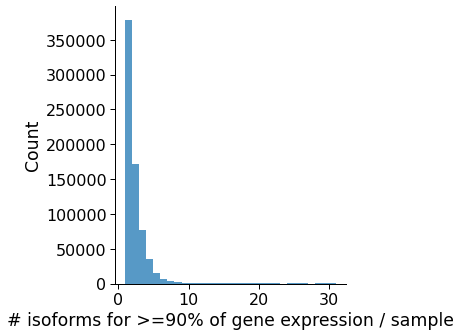

In [26]:
sns.set_context('paper', font_scale=1.8)
ax = sns.displot(data=iso_df, x='n_isos',
                 kind='hist',
                 binwidth=1,
                 linewidth=0)

xlabel = '# isoforms for >=90% of gene expression / sample'
ylabel = 'Count'

_ = ax.set(xlabel=xlabel, ylabel=ylabel)
fname = '{}_isos_pi_90.png'.format(opref)
plt.savefig(fname, dpi=300, bbox_inches='tight')   

### Gene-level exon analysis

Read in graph from swan.p
Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1094: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1093: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 194503
# isos >= 1 tpm: 175394
Applying gene type and novelty subset
Number of isos reported: 111071
Found 50 total samples


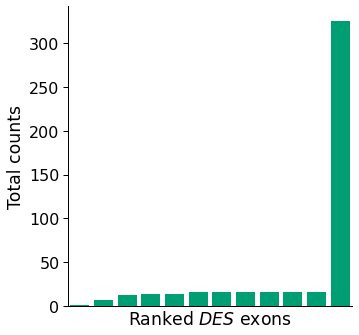

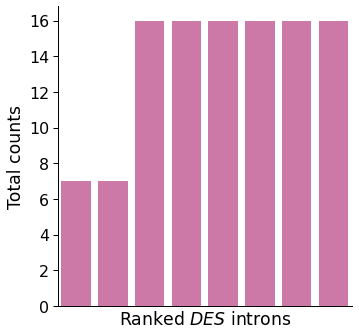

In [27]:
sg = swan.read('swan.p')
df = pd.read_csv('../talon/human_talon_abundance_filtered.tsv', sep='\t')
_ = plot_ranked_exon_counts(sg, df, 'DES', 
                        min_tpm=1, 
                        gene_subset='polya',
                        sample='all', 
                        groupby='sample', 
                        nov=['Known', 'NIC', 'NNC'], 
                        opref='figures/human')

Read in graph from swan.p
Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1094: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1093: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 194503
# isos >= 1 tpm: 175394
Applying gene type and novelty subset
Number of isos reported: 111071
Found 50 total samples


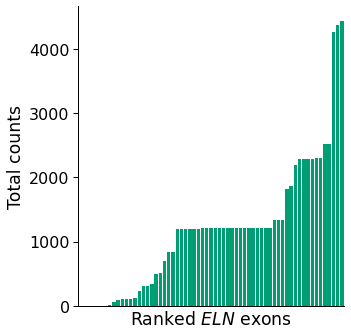

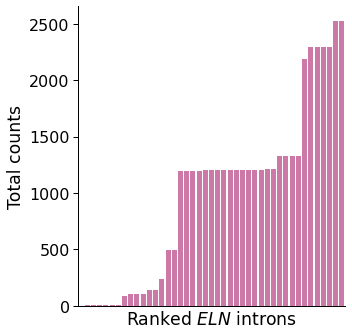

In [28]:
sg = swan.read('swan.p')
df = pd.read_csv('../talon/human_talon_abundance_filtered.tsv', sep='\t')
_ = plot_ranked_exon_counts(sg, df, 'ELN', 
                        min_tpm=1, 
                        gene_subset='polya',
                        sample='all', 
                        groupby='sample', 
                        nov=['Known', 'NIC', 'NNC'], 
                        opref='figures/human')

Read in graph from swan.p
Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1094: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1093: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 194503
# isos >= 1 tpm: 175394
Applying gene type and novelty subset
Number of isos reported: 111071
Found 50 total samples
Found 139 isoforms for ELN


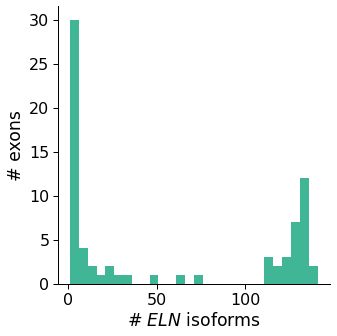

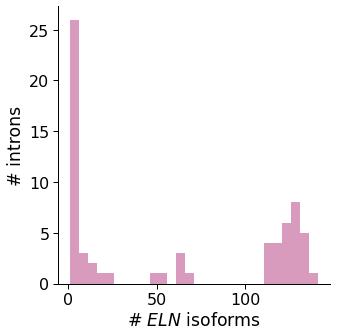

In [29]:
sg = swan.read('swan.p')
df = pd.read_csv('../talon/human_talon_abundance_filtered.tsv', sep='\t')
plot_exon_hist(sg, df, 'ELN',
               min_tpm=1,
               gene_subset='polya',
               sample='all', 
               groupby='sample', 
               nov=['Known', 'NIC', 'NNC'], 
               opref='figures/human')

In [30]:
sg.plot_graph('ELN', indicate_novel=True, prefix='figures/eln')

Saving summary graph for ENSG00000049540.16 as figures/eln_novel_ENSG00000049540.16_summary.png


In [31]:
sg.plot_graph('DES', indicate_novel=True, prefix='figures/des')

Saving summary graph for ENSG00000175084.11 as figures/des_novel_ENSG00000175084.11_summary.png


In [32]:
sg.plot_transcript_path('ENST00000373960.3', indicate_novel=True, prefix='figures/des')

Saving transcript path graph for ENST00000373960.3 as figures/des_novel_ENST00000373960.3_path.png


In [33]:
sg.plot_transcript_path('ENCODEHT002835059', indicate_novel=True, prefix='figures/des')

Saving transcript path graph for ENCODEHT002835059 as figures/des_novel_ENCODEHT002835059_path.png


## AD reports

In [7]:
sg.adata.obs.head()

,dataset,total_counts,sample,classification,health_status
index,,,,,
gm12878_1_1,gm12878_1_1,598749.0,gm12878,cell_line,NaN
gm12878_1_2,gm12878_1_2,519722.0,gm12878,cell_line,NaN
gm12878_1_3,gm12878_1_3,452616.0,gm12878,cell_line,NaN
gm12878_1_4,gm12878_1_4,566726.0,gm12878,cell_line,NaN
gm12878_3_1,gm12878_3_1,885570.0,gm12878,cell_line,NaN


In [2]:
import swan_vis as swan
sg = swan.read('swan.p')

def plot_rush_report(sg, gene):
    opref = 'figures/rush_{}'.format(gene)
    sg.gen_report(gene,
              prefix=opref,
              layer='pi',
              cmap='magma',
              novelty=True,
              metadata_cols=['health_status'],
              datasets={'health_status': ['healthy', 'AD'], 'sample': 'brain'},
              transcript_col='tname',
              browser=True)
    
    sg.gen_report(gene,
          prefix=opref,
          layer='tpm',
          cmap='viridis',
          novelty=True,
          metadata_cols=['health_status'],
          datasets={'health_status': ['healthy', 'AD'], 'sample': 'brain'},
          transcript_col='tname')
    

Read in graph from swan.p


In [3]:
plot_rush_report(sg, 'SCN1A')

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/swan_vis/swangraph.py:1050: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  t_df['sum'] = np.log2(t_df+1).sum(axis=1)


                   brodmann_area_46_1_1  brodmann_area_46_7_1  \
tid                                                             
ENST00000507401.2                 100.0                 100.0   

                   brodmann_area_46_2_1  brodmann_area_46_3_1  \
tid                                                             
ENST00000507401.2                 100.0                 100.0   

                   brodmann_area_46_5_1  brodmann_area_46_6_1  \
tid                                                             
ENST00000507401.2                 100.0                 100.0   

                   brodmann_area_46_8_1  brodmann_area_46_4_1  \
tid                                                             
ENST00000507401.2                 100.0                 100.0   

                   brodmann_area_46_9_1  
tid                                      
ENST00000507401.2                 100.0  

Plotting transcripts for ENSG00000144285.19
Saving transcript path graph for ENST00000507

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/swan_vis/swangraph.py:1050: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  t_df['sum'] = np.log2(t_df+1).sum(axis=1)


                   brodmann_area_46_1_1  brodmann_area_46_7_1  \
ENST00000507401.2              4.359122               4.32092   

                   brodmann_area_46_2_1  brodmann_area_46_3_1  \
ENST00000507401.2              6.194194              2.078769   

                   brodmann_area_46_5_1  brodmann_area_46_6_1  \
ENST00000507401.2              2.979037              3.480799   

                   brodmann_area_46_8_1  brodmann_area_46_4_1  \
ENST00000507401.2              9.954995              2.616174   

                   brodmann_area_46_9_1  
ENST00000507401.2              6.228615  

Plotting transcripts for ENSG00000144285.19
Saving transcript path graph for ENST00000507401.2 as figures/rush_SCN1A_ENST00000507401.2_path.png
Generating report for ENSG00000144285.19


In [16]:
plot_rush_report(sg, 'SPP1')

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/swan_vis/swangraph.py:1050: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  t_df['sum'] = np.log2(t_df+1).sum(axis=1)


                    brodmann_area_46_1_1  brodmann_area_46_7_1  \
tid                                                              
ENST00000395080.7              52.884613             68.181816   
ENST00000237623.11             35.576923             29.338842   
ENST00000360804.4              11.538462              1.652892   
ENST00000508233.5               0.000000              0.826446   
ENST00000504310.5               0.000000              0.000000   

                    brodmann_area_46_2_1  brodmann_area_46_3_1  \
tid                                                              
ENST00000395080.7              66.292137             60.638298   
ENST00000237623.11             26.966291             34.042553   
ENST00000360804.4               6.581059              5.319149   
ENST00000508233.5               0.160514              0.000000   
ENST00000504310.5               0.000000              0.000000   

                    brodmann_area_46_5_1  brodmann_area_46_6_1  \
tid     

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/swan_vis/swangraph.py:1050: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  t_df['sum'] = np.log2(t_df+1).sum(axis=1)


                    brodmann_area_46_1_1  brodmann_area_46_7_1  \
ENST00000395080.7             239.751694            142.590347   
ENST00000237623.11            161.287506             61.357059   
ENST00000360804.4              52.309464              3.456736   
ENST00000508233.5               0.000000              1.728368   
ENST00000504310.5               0.000000              0.000000   

                    brodmann_area_46_2_1  brodmann_area_46_3_1  \
ENST00000395080.7             426.367035            355.469452   
ENST00000237623.11            173.437439            199.561798   
ENST00000360804.4              42.326992             31.181530   
ENST00000508233.5               1.032366              0.000000   
ENST00000504310.5               0.000000              0.000000   

                    brodmann_area_46_5_1  brodmann_area_46_6_1  \
ENST00000395080.7             399.190887            968.242310   
ENST00000237623.11            188.424057            430.458832   
ENST0000

In [13]:
plot_rush_report(sg, 'MAPT')

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/swan_vis/swangraph.py:1050: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  t_df['sum'] = np.log2(t_df+1).sum(axis=1)


                    brodmann_area_46_1_1  brodmann_area_46_7_1  \
tid                                                              
ENST00000334239.12             33.333336             14.285715   
ENST00000340799.9              66.666672             50.000000   
ENST00000446361.7               0.000000             23.809525   
ENST00000535772.5               0.000000              2.380952   
ENST00000572440.1               0.000000              0.000000   

                    brodmann_area_46_2_1  brodmann_area_46_3_1  \
tid                                                              
ENST00000334239.12                  40.0             30.000002   
ENST00000340799.9                   24.0             30.000002   
ENST00000446361.7                   24.0             20.000000   
ENST00000535772.5                    0.0             10.000000   
ENST00000572440.1                    4.0              0.000000   

                    brodmann_area_46_5_1  brodmann_area_46_6_1  \
tid     

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/swan_vis/swangraph.py:1050: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  t_df['sum'] = np.log2(t_df+1).sum(axis=1)


                    brodmann_area_46_1_1  brodmann_area_46_7_1  \
ENST00000334239.12              4.359122              5.185104   
ENST00000340799.9               8.718244             18.147863   
ENST00000446361.7               0.000000              8.641840   
ENST00000535772.5               0.000000              0.864184   
ENST00000572440.1               0.000000              0.000000   

                    brodmann_area_46_2_1  brodmann_area_46_3_1  \
ENST00000334239.12             10.323657              6.236306   
ENST00000340799.9               6.194194              6.236306   
ENST00000446361.7               6.194194              4.157537   
ENST00000535772.5               0.000000              2.078769   
ENST00000572440.1               1.032366              0.000000   

                    brodmann_area_46_5_1  brodmann_area_46_6_1  \
ENST00000334239.12              9.681869              8.701998   
ENST00000340799.9               9.681869             10.442398   
ENST0000

In [14]:
plot_rush_report(sg, 'CST7')

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/swan_vis/swangraph.py:1050: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  t_df['sum'] = np.log2(t_df+1).sum(axis=1)


                   brodmann_area_46_1_1  brodmann_area_46_7_1  \
tid                                                             
ENST00000480798.1                   NaN                 100.0   

                   brodmann_area_46_2_1  brodmann_area_46_3_1  \
tid                                                             
ENST00000480798.1                 100.0                   NaN   

                   brodmann_area_46_5_1  brodmann_area_46_6_1  \
tid                                                             
ENST00000480798.1                 100.0                 100.0   

                   brodmann_area_46_8_1  brodmann_area_46_4_1  \
tid                                                             
ENST00000480798.1                   NaN                 100.0   

                   brodmann_area_46_9_1  
tid                                      
ENST00000480798.1                 100.0  

Plotting transcripts for ENSG00000077984.5
Saving transcript path graph for ENST000004807

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/swan_vis/swangraph.py:1050: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  t_df['sum'] = np.log2(t_df+1).sum(axis=1)


                   brodmann_area_46_1_1  brodmann_area_46_7_1  \
ENST00000480798.1                   0.0              0.864184   

                   brodmann_area_46_2_1  brodmann_area_46_3_1  \
ENST00000480798.1              5.161829                   0.0   

                   brodmann_area_46_5_1  brodmann_area_46_6_1  \
ENST00000480798.1              2.234277              1.160266   

                   brodmann_area_46_8_1  brodmann_area_46_4_1  \
ENST00000480798.1                   0.0              2.616174   

                   brodmann_area_46_9_1  
ENST00000480798.1              2.768273  

Plotting transcripts for ENSG00000077984.5
Saving transcript path graph for ENST00000480798.1 as figures/rush_CST7_ENST00000480798.1_path.png
Generating report for ENSG00000077984.5


In [15]:
plot_rush_report(sg, 'CSF1')

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/swan_vis/swangraph.py:1050: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  t_df['sum'] = np.log2(t_df+1).sum(axis=1)


                    brodmann_area_46_1_1  brodmann_area_46_7_1  \
tid                                                              
ENST00000329608.10                   NaN                  90.0   
ENST00000420111.6                    NaN                  10.0   
ENST00000369802.7                    NaN                   0.0   

                    brodmann_area_46_2_1  brodmann_area_46_3_1  \
tid                                                              
ENST00000329608.10             60.000004                  50.0   
ENST00000420111.6               0.000000                   0.0   
ENST00000369802.7              40.000000                  50.0   

                    brodmann_area_46_5_1  brodmann_area_46_6_1  \
tid                                                              
ENST00000329608.10             78.947372             66.666672   
ENST00000420111.6              10.526316             16.666668   
ENST00000369802.7              10.526316             16.666668   

       

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/swan_vis/swangraph.py:1050: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  t_df['sum'] = np.log2(t_df+1).sum(axis=1)


                    brodmann_area_46_1_1  brodmann_area_46_7_1  \
ENST00000329608.10                   0.0              7.777656   
ENST00000420111.6                    0.0              0.864184   
ENST00000369802.7                    0.0              0.000000   

                    brodmann_area_46_2_1  brodmann_area_46_3_1  \
ENST00000329608.10              3.097097              2.078769   
ENST00000420111.6               0.000000              0.000000   
ENST00000369802.7               2.064731              2.078769   

                    brodmann_area_46_5_1  brodmann_area_46_6_1  \
ENST00000329608.10             11.171387              4.641066   
ENST00000420111.6               1.489518              1.160266   
ENST00000369802.7               1.489518              1.160266   

                    brodmann_area_46_8_1  brodmann_area_46_4_1  \
ENST00000329608.10              8.295830              4.578305   
ENST00000420111.6               3.318332              2.616174   
ENST000

## Reports

In [15]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import swan_vis as swan 
from scipy import sparse

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [17]:
sg = swan.read('swan.p')

Read in graph from swan.p


In [18]:
c_dict, order = get_biosample_colors()

In [7]:
samples = list(set(order)&set(sg.adata.obs.loc[sg.adata.obs.classification == 'cell_line', 'sample'].unique().tolist()))
sg.gen_report('ELN',
              prefix='figures/eln_cell_line_tpm',
              layer='tpm',
              cmap='viridis',
              novelty=True,
              groupby='sample',
              transcript_col='ttrip',
              metadata_cols=['sample'],
              datasets={'sample': samples},
              browser=True)


Plotting transcripts for ENSG00000049540.16
Saving transcript path graph for ENCODEHT001481409 as figures/eln_cell_line_tpm_browser_ENCODEHT001481409_path.png
Saving transcript path graph for ENST00000380576.9 as figures/eln_cell_line_tpm_browser_ENST00000380576.9_path.png
Saving transcript path graph for ENST00000445912.5 as figures/eln_cell_line_tpm_browser_ENST00000445912.5_path.png
Saving transcript path graph for ENST00000252034.11 as figures/eln_cell_line_tpm_browser_ENST00000252034.11_path.png
Saving transcript path graph for ENCODEHT002323610 as figures/eln_cell_line_tpm_browser_ENCODEHT002323610_path.png
Saving transcript path graph for ENCODEHT002323608 as figures/eln_cell_line_tpm_browser_ENCODEHT002323608_path.png
Saving transcript path graph for ENST00000380575.8 as figures/eln_cell_line_tpm_browser_ENST00000380575.8_path.png
Saving transcript path graph for ENCODEHT002323596 as figures/eln_cell_line_tpm_browser_ENCODEHT002323596_path.png
Saving transcript path graph for 

In [3]:
def make_biosamp_reports(sg, gene, order):
    def make_reports(sg, gene, c, order):
        opref = 'figures/{}_{}'.format(gene.lower(), c)
        samples = list(set(order)&set(sg.adata.obs.loc[sg.adata.obs.classification == c, 'sample'].unique().tolist()))
        sg.gen_report(gene,
                  prefix=opref,
                  layer='pi',
                  cmap='magma',
                  novelty=True,
                  groupby='sample',
                  metadata_cols=['sample'],
                  datasets={'sample': samples},
                  transcript_col='tname',
                  browser=True)

        sg.gen_report(gene,
                      prefix=opref,
                      layer='tpm',
                      cmap='viridis',
                      novelty=True,
                      groupby='sample',
                      metadata_cols=['sample'],
                      indicate_novel=True,
                      transcript_col='tname',
                      datasets={'sample': samples})
        
    c = 'tissue'
    make_reports(sg, gene, c, order)
    c = 'cell_line'
    make_reports(sg, gene, c, order)    

In [9]:
make_biosamp_reports(sg, 'RPS29', order)

In [8]:
make_biosamp_reports(sg, 'RN7SL1', order)

In [10]:
make_biosamp_reports(sg, 'AL139099.4', order)


Plotting transcripts for ENSG00000283029.1
Saving transcript path graph for ENST00000635274.1 as figures/al139099.4_tissue_browser_ENST00000635274.1_path.png
Generating report for ENSG00000283029.1

Plotting transcripts for ENSG00000283029.1
Saving transcript path graph for ENST00000635274.1 as figures/al139099.4_tissue_novel_ENST00000635274.1_path.png
Generating report for ENSG00000283029.1

Plotting transcripts for ENSG00000283029.1
Saving transcript path graph for ENST00000635274.1 as figures/al139099.4_cell_line_browser_ENST00000635274.1_path.png
Generating report for ENSG00000283029.1

Plotting transcripts for ENSG00000283029.1
Saving transcript path graph for ENST00000635274.1 as figures/al139099.4_cell_line_novel_ENST00000635274.1_path.png
Generating report for ENSG00000283029.1


In [19]:
make_biosamp_reports(sg, 'SCN8A', order)


Plotting transcripts for ENSG00000196876.15
Saving transcript path graph for ENST00000550891.4 as figures/scn8a_tissue_browser_ENST00000550891.4_path.png
Generating report for ENSG00000196876.15

Plotting transcripts for ENSG00000196876.15
Saving transcript path graph for ENST00000550891.4 as figures/scn8a_tissue_novel_ENST00000550891.4_path.png
Generating report for ENSG00000196876.15

Plotting transcripts for ENSG00000196876.15
Saving transcript path graph for ENST00000545061.5 as figures/scn8a_cell_line_browser_ENST00000545061.5_path.png
Generating report for ENSG00000196876.15

Plotting transcripts for ENSG00000196876.15
Saving transcript path graph for ENST00000545061.5 as figures/scn8a_cell_line_novel_ENST00000545061.5_path.png
Generating report for ENSG00000196876.15


In [24]:
make_biosamp_reports(sg, 'COL1A1', order)

In [18]:
make_biosamp_reports(sg, 'CAST')


Plotting transcripts for ENSG00000153113.23
Saving transcript path graph for ENCODEHT000470977 as figures/cast_tissue_browser_ENCODEHT000470977_path.png
Saving transcript path graph for ENST00000309190.9 as figures/cast_tissue_browser_ENST00000309190.9_path.png
Saving transcript path graph for ENCODEHT000470926 as figures/cast_tissue_browser_ENCODEHT000470926_path.png
Saving transcript path graph for ENCODEHT000470707 as figures/cast_tissue_browser_ENCODEHT000470707_path.png
Saving transcript path graph for ENCODEHT000471452 as figures/cast_tissue_browser_ENCODEHT000471452_path.png
Saving transcript path graph for ENCODEHT001378016 as figures/cast_tissue_browser_ENCODEHT001378016_path.png
Saving transcript path graph for ENCODEHT000471422 as figures/cast_tissue_browser_ENCODEHT000471422_path.png
Saving transcript path graph for ENST00000395813.5 as figures/cast_tissue_browser_ENST00000395813.5_path.png
Saving transcript path graph for ENCODEHT000471440 as figures/cast_tissue_browser_E

In [19]:
make_biosamp_reports(sg, 'GGT1')


Plotting transcripts for ENSG00000100031.18
Saving transcript path graph for ENCODEHT000414203 as figures/ggt1_tissue_browser_ENCODEHT000414203_path.png
Saving transcript path graph for ENCODEHT000414250 as figures/ggt1_tissue_browser_ENCODEHT000414250_path.png
Saving transcript path graph for ENST00000403838.5 as figures/ggt1_tissue_browser_ENST00000403838.5_path.png
Saving transcript path graph for ENST00000400382.5 as figures/ggt1_tissue_browser_ENST00000400382.5_path.png
Saving transcript path graph for ENCODEHT000414184 as figures/ggt1_tissue_browser_ENCODEHT000414184_path.png
Saving transcript path graph for ENCODEHT000414190 as figures/ggt1_tissue_browser_ENCODEHT000414190_path.png
Saving transcript path graph for ENCODEHT000414211 as figures/ggt1_tissue_browser_ENCODEHT000414211_path.png
Saving transcript path graph for ENCODEHT000414244 as figures/ggt1_tissue_browser_ENCODEHT000414244_path.png
Saving transcript path graph for ENCODEHT000414236 as figures/ggt1_tissue_browser_E

In [13]:
sg = swan.read('swan.p')
datasets = []
datasets += sg.adata.obs.loc[sg.adata.obs['sample'].str.contains('h9'), 'sample'].unique().tolist()
datasets += sg.adata.obs.loc[sg.adata.obs['sample'].str.contains('pgp1'), 'sample'].unique().tolist()
datasets.append('caco2')
print(datasets)

sg.gen_report('MEF2C',
              prefix='figures/mef2c_h9_pgp1_caco2',
              layer='pi',
              cmap='magma',
              novelty=True,
              groupby='sample',
              transcript_col='tname',
              metadata_cols=['sample'],
              datasets={'sample': datasets},
              browser=True)

Read in graph from swan.p
['h9', 'h9_chondro', 'h9_de', 'h9_neural_crest', 'h9_osteocyte', 'h9_panc_progen', 'h9_panc_beta', 'pgp1', 'pgp1_astro', 'pgp1_endo', 'pgp1_excite_neuron', 'caco2']
                   h9  h9_chondro  h9_de  h9_neural_crest  h9_osteocyte  \
tid                                                                       
ENST00000510942.5 NaN   40.000000   50.0        35.507248     17.500000   
ENST00000508569.5 NaN   17.500000    0.0        18.115942     20.000000   
ENCODEHT000458385 NaN   30.000002    0.0        21.014492     30.000002   
ENCODEHT000458453 NaN   10.000000    0.0        22.463768     30.000002   
ENST00000511086.1 NaN    0.000000   50.0         0.724638      0.000000   

                   h9_panc_progen  h9_panc_beta  pgp1  pgp1_astro  pgp1_endo  \
tid                                                                            
ENST00000510942.5             0.0     31.578945   NaN    0.000000  38.461540   
ENST00000508569.5             0.0     31.57

In [20]:
sg.gen_report('ELN',
              prefix='figures/eln_cell_line_pi',
              layer='pi',
              cmap='magma',
              novelty=True,
              groupby='sample',
              transcript_name=True,
              metadata_cols=['sample'],
              datasets={'classification': 'cell_line'},
              browser=True)


Plotting transcripts for ENSG00000049540.16
Saving transcript path graph for ENCODEHT001481409 as figures/eln_cell_line_pi_browser_ENCODEHT001481409_path.png
Saving transcript path graph for ENST00000380576.9 as figures/eln_cell_line_pi_browser_ENST00000380576.9_path.png
Saving transcript path graph for ENST00000445912.5 as figures/eln_cell_line_pi_browser_ENST00000445912.5_path.png
Saving transcript path graph for ENST00000252034.11 as figures/eln_cell_line_pi_browser_ENST00000252034.11_path.png
Saving transcript path graph for ENCODEHT002323610 as figures/eln_cell_line_pi_browser_ENCODEHT002323610_path.png
Saving transcript path graph for ENCODEHT002323608 as figures/eln_cell_line_pi_browser_ENCODEHT002323608_path.png
Saving transcript path graph for ENST00000380575.8 as figures/eln_cell_line_pi_browser_ENST00000380575.8_path.png
Saving transcript path graph for ENCODEHT002323596 as figures/eln_cell_line_pi_browser_ENCODEHT002323596_path.png
Saving transcript path graph for ENCODEHT

In [32]:
samples = [o for o in order if o in sg.adata.obs.loc[sg.adata.obs.classification == 'cell_line', 'sample'].tolist()]
print(samples)
sg.gen_report('ELN',
              prefix='figures/eln_cell_line_tpm',
              layer='tpm',
              cmap='viridis',
              novelty=True,
              groupby='sample',
              transcript_name=True,
              metadata_cols=['sample'],
              datasets={'sample': samples},
              browser=True)

['hffc6', 'h1', 'h1_de', 'h9', 'h9_chondro', 'h9_de', 'h9_panc_beta', 'h9_osteocyte', 'h9_panc_progen', 'h9_neural_crest', 'hl60', 'hl60_m0', 'hl60_m1_12hr', 'hl60_m1_24hr', 'hl60_m1_72hr', 'hl60_m2_12hr', 'hl60_m2_24hr', 'hl60_m2_72hr', 'a673', 'caco2', 'calu3', 'gm12878', 'hct116', 'hepg2', 'hmec', 'huvec', 'imr90', 'k562', 'mcf10a', 'mcf7', 'ocily7', 'panc1', 'pc3', 'pc9', 'wtc11', 'pgp1', 'pgp1_astro', 'pgp1_endo', 'pgp1_excite_neuron']

Plotting transcripts for ENSG00000049540.16
Saving transcript path graph for ENCODEHT001481409 as figures/eln_cell_line_tpm_browser_ENCODEHT001481409_path.png
Saving transcript path graph for ENST00000380576.9 as figures/eln_cell_line_tpm_browser_ENST00000380576.9_path.png
Saving transcript path graph for ENST00000445912.5 as figures/eln_cell_line_tpm_browser_ENST00000445912.5_path.png
Saving transcript path graph for ENST00000252034.11 as figures/eln_cell_line_tpm_browser_ENST00000252034.11_path.png
Saving transcript path graph for ENCODEHT0023236

In [21]:
sg.gen_report('ELN',
              prefix='figures/eln_cell_line',
              layer='tpm',
              cmap='viridis',
              novelty=True,
              groupby='sample',
              transcript_name=True,
              metadata_cols=['sample'],
              datasets={'classification': 'cell_line'},
              browser=True)


Plotting transcripts for ENSG00000049540.16
Saving transcript path graph for ENCODEHT001481409 as figures/eln_cell_line_browser_ENCODEHT001481409_path.png
Saving transcript path graph for ENST00000380576.9 as figures/eln_cell_line_browser_ENST00000380576.9_path.png
Saving transcript path graph for ENST00000445912.5 as figures/eln_cell_line_browser_ENST00000445912.5_path.png
Saving transcript path graph for ENST00000252034.11 as figures/eln_cell_line_browser_ENST00000252034.11_path.png
Saving transcript path graph for ENCODEHT002323610 as figures/eln_cell_line_browser_ENCODEHT002323610_path.png
Saving transcript path graph for ENCODEHT002323608 as figures/eln_cell_line_browser_ENCODEHT002323608_path.png
Saving transcript path graph for ENST00000380575.8 as figures/eln_cell_line_browser_ENST00000380575.8_path.png
Saving transcript path graph for ENCODEHT002323596 as figures/eln_cell_line_browser_ENCODEHT002323596_path.png
Saving transcript path graph for ENCODEHT002323593 as figures/eln

In [22]:
make_biosamp_reports(sg, 'MYOG')


Plotting transcripts for ENSG00000122180.4
Saving transcript path graph for ENST00000241651.4 as figures/myog_tissue_browser_ENST00000241651.4_path.png
Generating report for ENSG00000122180.4

Plotting transcripts for ENSG00000122180.4
Saving transcript path graph for ENST00000241651.4 as figures/myog_tissue_novel_ENST00000241651.4_path.png
Generating report for ENSG00000122180.4

Plotting transcripts for ENSG00000122180.4
Saving transcript path graph for ENCODEHT002380206 as figures/myog_cell_line_browser_ENCODEHT002380206_path.png
Saving transcript path graph for ENST00000241651.4 as figures/myog_cell_line_browser_ENST00000241651.4_path.png
Generating report for ENSG00000122180.4

Plotting transcripts for ENSG00000122180.4
Saving transcript path graph for ENCODEHT002380206 as figures/myog_cell_line_novel_ENCODEHT002380206_path.png
Saving transcript path graph for ENST00000241651.4 as figures/myog_cell_line_novel_ENST00000241651.4_path.png
Generating report for ENSG00000122180.4


In [9]:
make_biosamp_reports(sg, 'RORC', order)


Plotting transcripts for ENSG00000143365.17
Saving transcript path graph for ENST00000318247.6 as figures/rorc_tissue_browser_ENST00000318247.6_path.png
Saving transcript path graph for ENST00000638901.1 as figures/rorc_tissue_browser_ENST00000638901.1_path.png
Saving transcript path graph for ENST00000480719.1 as figures/rorc_tissue_browser_ENST00000480719.1_path.png
Saving transcript path graph for ENST00000356728.10 as figures/rorc_tissue_browser_ENST00000356728.10_path.png
Generating report for ENSG00000143365.17

Plotting transcripts for ENSG00000143365.17
Saving transcript path graph for ENST00000318247.6 as figures/rorc_tissue_novel_ENST00000318247.6_path.png
Saving transcript path graph for ENST00000638901.1 as figures/rorc_tissue_novel_ENST00000638901.1_path.png
Saving transcript path graph for ENST00000480719.1 as figures/rorc_tissue_novel_ENST00000480719.1_path.png
Saving transcript path graph for ENST00000356728.10 as figures/rorc_tissue_novel_ENST00000356728.10_path.png
G

In [12]:
make_biosamp_reports(sg, 'CALD1', order)


Plotting transcripts for ENSG00000122786.19
Saving transcript path graph for ENST00000361901.6 as figures/cald1_tissue_browser_ENST00000361901.6_path.png
Saving transcript path graph for ENST00000424922.5 as figures/cald1_tissue_browser_ENST00000424922.5_path.png
Saving transcript path graph for ENST00000361675.6 as figures/cald1_tissue_browser_ENST00000361675.6_path.png
Saving transcript path graph for ENCODEHT000782654 as figures/cald1_tissue_browser_ENCODEHT000782654_path.png
Saving transcript path graph for ENCODEHT001669192 as figures/cald1_tissue_browser_ENCODEHT001669192_path.png
Saving transcript path graph for ENCODEHT002711489 as figures/cald1_tissue_browser_ENCODEHT002711489_path.png
Saving transcript path graph for ENST00000480638.1 as figures/cald1_tissue_browser_ENST00000480638.1_path.png
Saving transcript path graph for ENCODEHT000782818 as figures/cald1_tissue_browser_ENCODEHT000782818_path.png
Saving transcript path graph for ENCODEHT000782725 as figures/cald1_tissue_

In [7]:
make_biosamp_reports(sg, 'MEF2C', order)

                       heart     brain      colon    vessels    adipose  \
tid                                                                       
ENST00000510942.5  26.022306  2.910053  53.333336  30.357143  33.333336   
ENCODEHT000458385  24.163570  1.851852  26.666668  25.892857  16.666668   
ENCODEHT000458453  22.304832  2.645503   0.000000  16.964285  20.833332   
ENST00000508569.5  20.817844  1.322751  20.000000  20.535715  16.666668   
ENST00000511086.1   3.345725  3.703704   0.000000   2.678571  12.500000   

                   adrenal gland      ovary       lung     muscle     kidney  \
tid                                                                            
ENST00000510942.5      31.818182  41.052631  34.615387   3.448276  22.222223   
ENCODEHT000458385      29.545454  21.052631  28.205130  10.344828  22.222223   
ENCODEHT000458453      17.045454  16.842106  17.948719   0.000000  44.444447   
ENST00000508569.5      18.181818  15.789473  12.820514   0.000000  11.1111

In [24]:
make_biosamp_reports(sg, 'ELN')


Plotting transcripts for ENSG00000049540.16
Saving transcript path graph for ENST00000445912.5 as figures/eln_tissue_browser_ENST00000445912.5_path.png
Saving transcript path graph for ENST00000252034.11 as figures/eln_tissue_browser_ENST00000252034.11_path.png
Saving transcript path graph for ENCODEHT001481409 as figures/eln_tissue_browser_ENCODEHT001481409_path.png
Saving transcript path graph for ENST00000380576.9 as figures/eln_tissue_browser_ENST00000380576.9_path.png
Saving transcript path graph for ENCODEHT002323610 as figures/eln_tissue_browser_ENCODEHT002323610_path.png
Saving transcript path graph for ENCODEHT002323608 as figures/eln_tissue_browser_ENCODEHT002323608_path.png
Saving transcript path graph for ENCODEHT002323596 as figures/eln_tissue_browser_ENCODEHT002323596_path.png
Saving transcript path graph for ENST00000458204.5 as figures/eln_tissue_browser_ENST00000458204.5_path.png
Saving transcript path graph for ENST00000380575.8 as figures/eln_tissue_browser_ENST0000

In [25]:
make_biosamp_reports(sg, 'DES')


Plotting transcripts for ENSG00000175084.11
Saving transcript path graph for ENST00000373960.3 as figures/des_tissue_browser_ENST00000373960.3_path.png
Saving transcript path graph for ENST00000483395.1 as figures/des_tissue_browser_ENST00000483395.1_path.png
Saving transcript path graph for ENCODEHT002835059 as figures/des_tissue_browser_ENCODEHT002835059_path.png
Saving transcript path graph for ENCODEHT001014840 as figures/des_tissue_browser_ENCODEHT001014840_path.png
Saving transcript path graph for ENCODEHT002835660 as figures/des_tissue_browser_ENCODEHT002835660_path.png
Saving transcript path graph for ENCODEHT002836352 as figures/des_tissue_browser_ENCODEHT002836352_path.png
Saving transcript path graph for ENCODEHT002836491 as figures/des_tissue_browser_ENCODEHT002836491_path.png
Saving transcript path graph for ENCODEHT002339506 as figures/des_tissue_browser_ENCODEHT002339506_path.png
Saving transcript path graph for ENCODEHT002835519 as figures/des_tissue_browser_ENCODEHT00

In [11]:
make_biosamp_reports('MYH7')

In [ ]:
sg.set_metadata_colors('classification', {'cell_line': 'blue', 'tissue': 'pink'})
sg.gen_report('MYH7',
              prefix='figures/myh7_cell_line',
              layer='tpm',
              cmap='viridis',
              novelty=True,
              groupby='sample',
              transcript_name=True,
              metadata_cols=['classification', 'sample'],
              browser=True)

In [ ]:
sg.adata.obs.head()

# where are the TSSs for Elastin?

In [ ]:
df = sg.get_tss_abundance(kind='tpm')
df = df.loc[df.gname == 'ELN']

In [ ]:
df

In [ ]:
df.coord.max()-df.coord.min()

In [ ]:
df.coord.max()

In [ ]:
df.coord.min()

In [ ]:
tids = ['ENCODEHT001481409', 'ELN-209']

sg.t_df.loc[sg.t_df.tname.isin(tids), ['tname', 'loc_path']]

In [ ]:
beep = sg.t_df.loc[sg.t_df.gname == 'ELN']

In [ ]:
beep['tss'] = beep.apply(lambda x: x.loc_path[0], axis=1)
beep = beep.merge(df[['vertex_id', 'coord']], how='left', left_on='tss', right_on='vertex_id')

In [ ]:
beep.loc[beep.tss == 822009]

In [ ]:
df.head()

In [ ]:
# are the isoforms with the super far away tsss even expresed?
far_tss = [822009, 822011, 821967, 821992, 821989]
for tss in far_tss:
    print(df.loc[df.vertex_id == tss, sg.datasets].sum(axis=1))

In [ ]:
df.sort_values(by='coord')

In [ ]:
74027789-74028188

## Where are the TESs for MEF2C?

In [ ]:
sg.plot_graph('MEF2C')

In [ ]:
tids = sg.adata.var.index.tolist()
paths = sg.t_df.loc_path.values.tolist()
tess = [path[-1] for path in paths]
sg.t_df['tes'] = tess

sg.t_df.loc[(sg.t_df.index.isin(tids))&(sg.t_df.gname == 'MEF2C'), 'tes'].nunique()

In [ ]:
counts.loc[counts.gname == 'MEF2C'].sort_values(by='tes', ascending=False)

In [ ]:
annot_counts.loc[annot_counts.gname == 'MEF2C']

In [ ]:
obs_counts.loc[obs_counts.gname == 'MEF2C']